# Building my first Adverserial Variational AutoEncoder
💪🏻😎😁


# Importing Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
from tensorflow.keras.models import *

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt


!echo "All packages Successfully imported"

All packages Successfully imported


# Downloading Fashion MNIST Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32')/255.
X_test = X_test.astype('float32') /255.

print()
print(f"Shape of Train Data: {X_train.shape}")
print(f"Shape of Test Data: {X_test.shape}")

4423680/4422102 [==============================] - 0s 0us/step

Shape of Train Data: (60000, 28, 28)
Shape of Test Data: (10000, 28, 28)


In [ ]:
fashionMNIST_classes = {0:"T-shirt/top", 1:"Trouser",
                        2:"Pullover", 3:"Dress",
                        4:"Coat", 5:"Sandal",
                        6:"Shirt", 7:"Sneaker", 
                        8:"Bag", 9:"Ankle boot"}

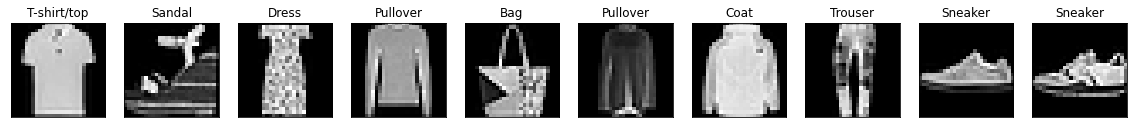

In [ ]:
n = 10
plt.figure(figsize = (20, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    idx = np.random.randint(i, len(X_train))
    plt.imshow(X_train[idx], cmap = 'binary')
    plt.title(fashionMNIST_classes[y_train[idx]])
    plt.gray()
    plt.xticks([]); plt.yticks([])
plt.show()


# Creating a Sampling Function 

In [ ]:
img_shape = (28, 28, 1)
latent_dim = 10
batch_size = 16
epsilon_std = 1.0

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (batch_size, latent_dim),
                            mean = 0.0,
                            stddev = epsilon_std
                            )
    return z_mean + K.exp(z_log_var/2)*epsilon

# Building Encoder, Decoder, Discriminator

In [ ]:
def build_encoder():
    ip = Input(shape = img_shape)
    hl = Flatten()(ip)
    hl = Dense(512, kernel_initializer='he_uniform')(hl)
    hl = LeakyReLU(alpha = 0.2)(hl)
    hl = Dense(512, kernel_initializer='he_uniform')(hl)
    hl = LeakyReLU(alpha = 0.2)(hl)
    mu = Dense(latent_dim)(hl)
    log_var = Dense(latent_dim)(hl)
    z = Lambda(sampling, output_shape = (latent_dim), name = "latent_rep")([mu, log_var])
    return Model(ip, z, name = "Encoder")


In [ ]:
def build_decoder():
    model = Sequential()
    model.add(Dense(512, input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(512, kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(np.prod(img_shape), activation = 'tanh'))
    model.add(Reshape(img_shape))
    print(model.summary())
    
    z = Input(shape = latent_dim)
    img = model(z)

    return Model(inputs = z, outputs = img, name = "Decoder")

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(1024, input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(512, kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation = 'sigmoid'))

    print(model.summary())

    enc_rep = Input(shape = (latent_dim))
    validity = model(enc_rep)

    return Model(enc_rep, validity, name = "Discriminator")

In [ ]:
optimizer = Adam(0.0002, 0.5)

# Discriminator
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = optimizer,
                      metrics = ['accuracy'])

# Encoder & Decoder
encoder = build_encoder()
decoder = build_decoder()

img = Input(shape = img_shape)

enc_rep = encoder(img)
reconst_img = decoder(enc_rep)


discriminator.trainable = False
validity = discriminator(enc_rep)

aae = Model(img, [reconst_img, validity])
aae.compile(loss = ['mse', 'binary_crossentropy'],
            loss_weights = [0.999, 0.001],
            optimizer = optimizer)

aae.trainable = True

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1024)              11264     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                

# Building a Customized training Function

In [ ]:
def train(epochs, batch_size = 128, sample_interval = 50):
    valid = np.ones((batch_size, 1))
    fake = np.ones((batch_size, 1))
    for epoch in range(epochs):

        # Training Discriminator and Generator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = encoder.predict(imgs)
        latent_real = np.random.normal(size = (batch_size, latent_dim))

        d_loss_real = discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
        d_loss = 1*np.add(d_loss_real, d_loss_fake)
        
        g_loss = aae.train_on_batch(imgs, [imgs, valid])

        # Plotting the progress
        if (epoch%sample_interval == 0):
            print()
            print("===============================")
            print(f"EPOCH: {epoch}")
            print("===============================")
            print(f"Discriminator Loss: {d_loss[0]}")
            print(f"Accuracy: {round(100*d_loss[1])}")
            print(f"Generator Loss: {g_loss[0]}")
            print(f"MSE: {g_loss[1]}")
            sample_images(epoch)
        
        if (discriminator.trainable_variables == False):
            discriminator.trainable = True
            aae.trainable = False
        elif (discriminator.trainable == True):
            discriminator.trainable = False
            aae.trainable = True



# Function For Displaying training Results

In [ ]:
def sample_images(epoch):
    r, c = 5, 5
    z = np.random.normal(size = (r*c, latent_dim))
    gen_imgs = decoder.predict(z)
    gen_imgs = 0.5*gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = plt.cm.binary)
            axs[i, j].axis('off')
            cnt += 1
    plt.show();
    fig.savefig(f"fashionMnist_{epoch}.png")
    plt.close()


# Let the Training Begins
## *You can see how the AAE is generating images from a random normal distribution*


EPOCH: 0
Discriminator Loss: 1.1781073808670044
Accuracy: 188
Generator Loss: 0.23097863793373108
MSE: 0.23074957728385925


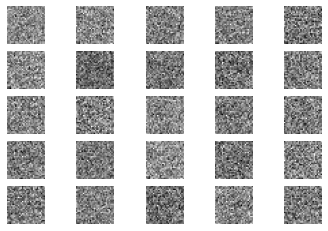


EPOCH: 50
Discriminator Loss: 0.0020068909507244825
Accuracy: 200
Generator Loss: 0.0409354642033577
MSE: 0.040976233780384064


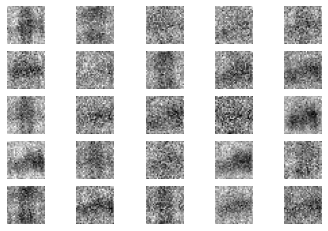


EPOCH: 100
Discriminator Loss: 0.000592348443289481
Accuracy: 200
Generator Loss: 0.03940221667289734
MSE: 0.039441656321287155


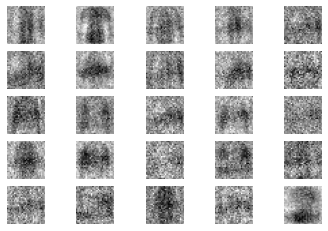


EPOCH: 150
Discriminator Loss: 0.0002266284147012243
Accuracy: 200
Generator Loss: 0.029924286529421806
MSE: 0.02995423972606659


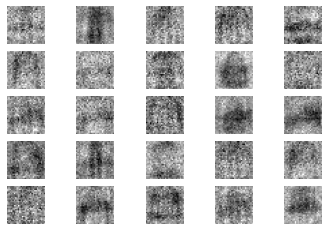


EPOCH: 200
Discriminator Loss: 0.00016481148895763909
Accuracy: 200
Generator Loss: 0.032342325896024704
MSE: 0.03237469121813774


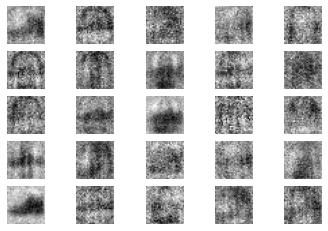


EPOCH: 250
Discriminator Loss: 0.00011395242472644895
Accuracy: 200
Generator Loss: 0.025896819308400154
MSE: 0.025922734290361404


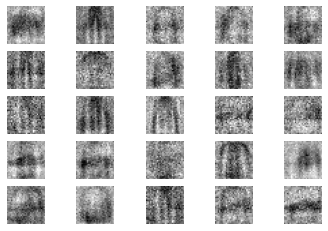


EPOCH: 300
Discriminator Loss: 9.410446501156855e-05
Accuracy: 200
Generator Loss: 0.030333269387483597
MSE: 0.03036363236606121


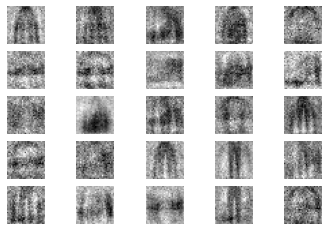


EPOCH: 350
Discriminator Loss: 2.7361995392993776e-05
Accuracy: 200
Generator Loss: 0.025459500029683113
MSE: 0.02548498474061489


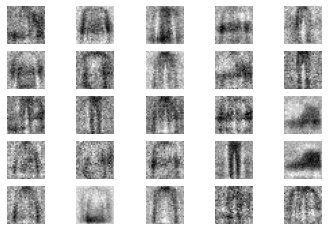


EPOCH: 400
Discriminator Loss: 5.5027079581160265e-05
Accuracy: 200
Generator Loss: 0.026849010959267616
MSE: 0.02687588706612587


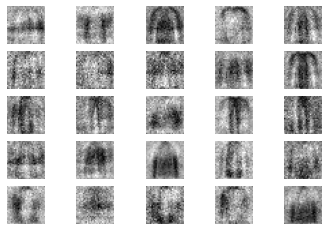


EPOCH: 450
Discriminator Loss: 6.14495035833329e-05
Accuracy: 200
Generator Loss: 0.028923824429512024
MSE: 0.02895277738571167


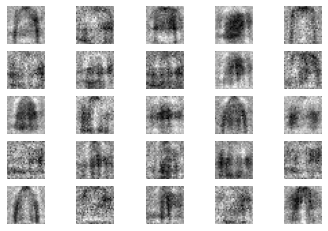


EPOCH: 500
Discriminator Loss: 3.159650327688723e-05
Accuracy: 200
Generator Loss: 0.026154890656471252
MSE: 0.026181071996688843


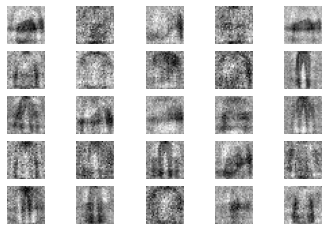


EPOCH: 550
Discriminator Loss: 4.725930787685684e-05
Accuracy: 200
Generator Loss: 0.024682605639100075
MSE: 0.024707311764359474


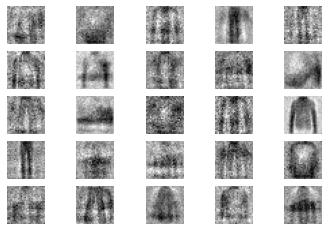


EPOCH: 600
Discriminator Loss: 1.2900305495833209e-05
Accuracy: 200
Generator Loss: 0.02361651323735714
MSE: 0.02364015392959118


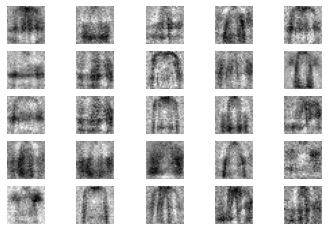


EPOCH: 650
Discriminator Loss: 5.99655868356308e-05
Accuracy: 200
Generator Loss: 0.019000882282853127
MSE: 0.019019901752471924


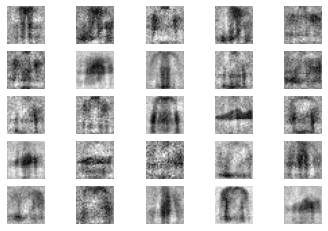


EPOCH: 700
Discriminator Loss: 1.061630682807832e-05
Accuracy: 200
Generator Loss: 0.024054421111941338
MSE: 0.024078499525785446


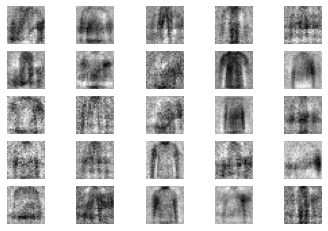


EPOCH: 750
Discriminator Loss: 9.668727670941735e-06
Accuracy: 200
Generator Loss: 0.02559424750506878
MSE: 0.025619864463806152


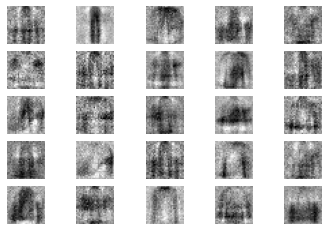


EPOCH: 800
Discriminator Loss: 7.238936746034597e-06
Accuracy: 200
Generator Loss: 0.02025575190782547
MSE: 0.02027602680027485


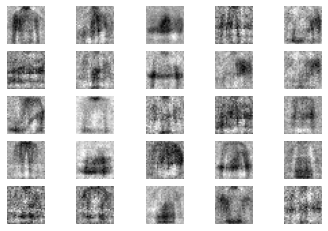


EPOCH: 850
Discriminator Loss: 5.770545099814672e-06
Accuracy: 200
Generator Loss: 0.02067670412361622
MSE: 0.020697401836514473


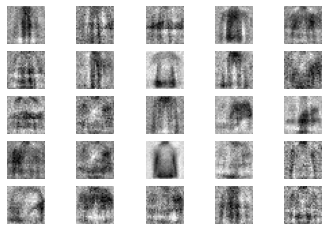


EPOCH: 900
Discriminator Loss: 1.493198396929074e-05
Accuracy: 200
Generator Loss: 0.024773353710770607
MSE: 0.02479814924299717


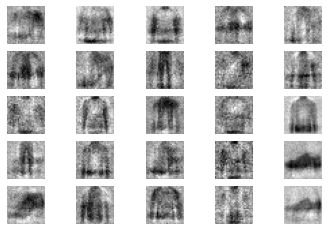


EPOCH: 950
Discriminator Loss: 2.457590063009718e-06
Accuracy: 200
Generator Loss: 0.02265373058617115
MSE: 0.022676406428217888


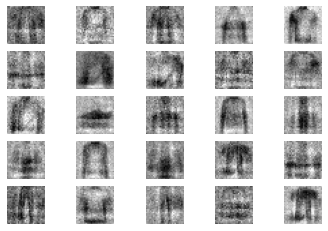


EPOCH: 1000
Discriminator Loss: 4.90013190629357e-06
Accuracy: 200
Generator Loss: 0.016661187633872032
MSE: 0.016677865758538246


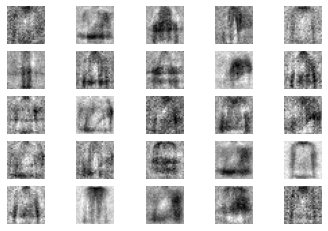


EPOCH: 1050
Discriminator Loss: 1.1631299384209925e-05
Accuracy: 200
Generator Loss: 0.024247245863080025
MSE: 0.024271517992019653


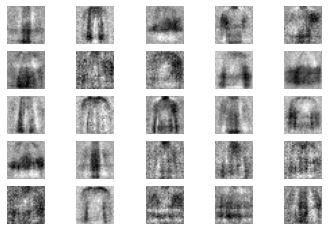


EPOCH: 1100
Discriminator Loss: 3.079855044063606e-05
Accuracy: 200
Generator Loss: 0.019731895998120308
MSE: 0.019751647487282753


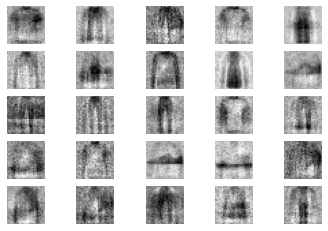


EPOCH: 1150
Discriminator Loss: 2.2552267071596077e-06
Accuracy: 200
Generator Loss: 0.02454943209886551
MSE: 0.024574005976319313


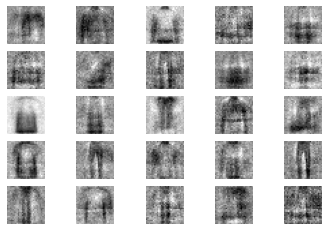


EPOCH: 1200
Discriminator Loss: 3.029735104576048e-06
Accuracy: 200
Generator Loss: 0.018999746069312096
MSE: 0.019018763676285744


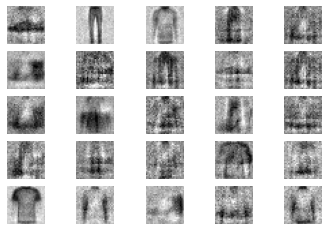


EPOCH: 1250
Discriminator Loss: 2.0245948562092053e-06
Accuracy: 200
Generator Loss: 0.018759340047836304
MSE: 0.0187781173735857


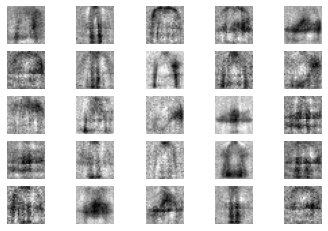


EPOCH: 1300
Discriminator Loss: 4.658642129840018e-06
Accuracy: 200
Generator Loss: 0.017066441476345062
MSE: 0.01708352565765381


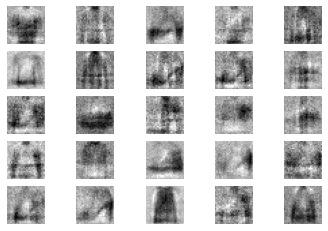


EPOCH: 1350
Discriminator Loss: 1.0161328516833379e-05
Accuracy: 200
Generator Loss: 0.017807601019740105
MSE: 0.017825426533818245


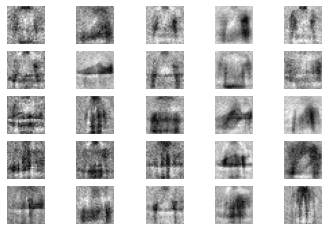


EPOCH: 1400
Discriminator Loss: 6.99645909874036e-07
Accuracy: 200
Generator Loss: 0.02199001982808113
MSE: 0.022012030705809593


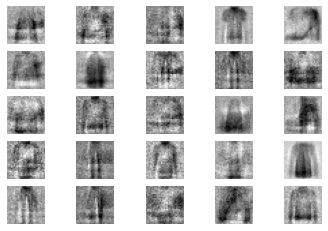


EPOCH: 1450
Discriminator Loss: 3.84855682922236e-06
Accuracy: 200
Generator Loss: 0.026962142437696457
MSE: 0.026989130303263664


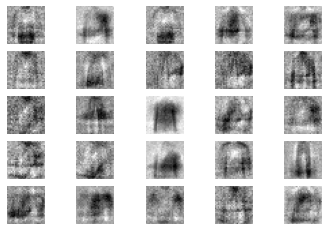


EPOCH: 1500
Discriminator Loss: 5.408876780216287e-07
Accuracy: 200
Generator Loss: 0.018469367176294327
MSE: 0.018487853929400444


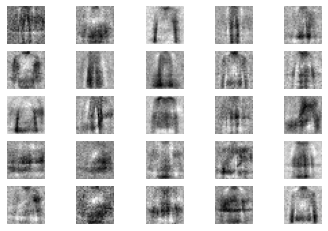


EPOCH: 1550
Discriminator Loss: 1.0374456567568968e-06
Accuracy: 200
Generator Loss: 0.021128809079527855
MSE: 0.021149959415197372


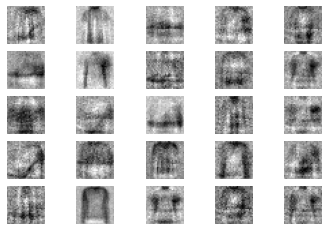


EPOCH: 1600
Discriminator Loss: 5.725761784702854e-07
Accuracy: 200
Generator Loss: 0.030946852639317513
MSE: 0.030977830290794373


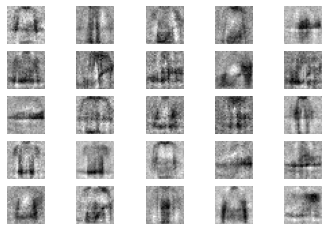


EPOCH: 1650
Discriminator Loss: 7.859522046516076e-07
Accuracy: 200
Generator Loss: 0.016613740473985672
MSE: 0.016630370169878006


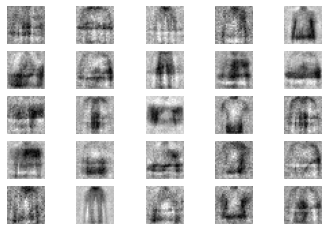


EPOCH: 1700
Discriminator Loss: 6.398964850024003e-06
Accuracy: 200
Generator Loss: 0.018451016396284103
MSE: 0.018469486385583878


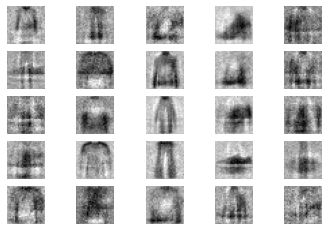


EPOCH: 1750
Discriminator Loss: 1.0635605576680973e-05
Accuracy: 200
Generator Loss: 0.020153863355517387
MSE: 0.02017403580248356


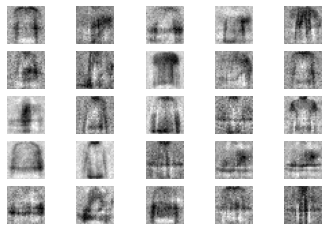


EPOCH: 1800
Discriminator Loss: 1.8025055359416342e-07
Accuracy: 200
Generator Loss: 0.019404346123337746
MSE: 0.019423769786953926


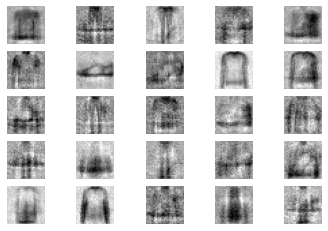


EPOCH: 1850
Discriminator Loss: 1.1004036394868244e-06
Accuracy: 200
Generator Loss: 0.018861372023820877
MSE: 0.018880251795053482


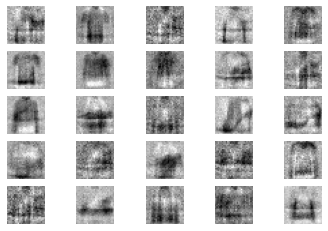


EPOCH: 1900
Discriminator Loss: 7.054510875015296e-06
Accuracy: 200
Generator Loss: 0.016679301857948303
MSE: 0.01669599674642086


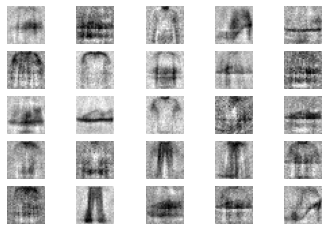


EPOCH: 1950
Discriminator Loss: 3.0363512948383686e-07
Accuracy: 200
Generator Loss: 0.018132178112864494
MSE: 0.0181503277271986


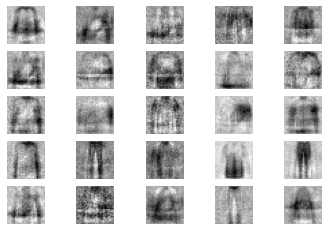


EPOCH: 2000
Discriminator Loss: 6.514331307716503e-07
Accuracy: 200
Generator Loss: 0.016762783750891685
MSE: 0.016779562458395958


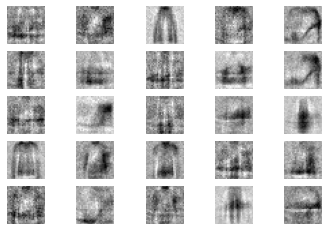


EPOCH: 2050
Discriminator Loss: 3.033548523490026e-07
Accuracy: 200
Generator Loss: 0.018706584349274635
MSE: 0.018725309520959854


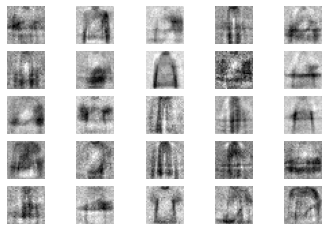


EPOCH: 2100
Discriminator Loss: 3.6173065909414666e-07
Accuracy: 200
Generator Loss: 0.01659110002219677
MSE: 0.016607707366347313


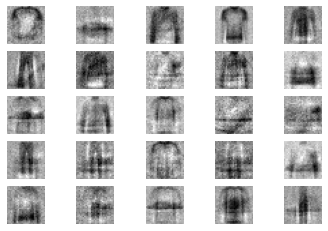


EPOCH: 2150
Discriminator Loss: 1.7684017505903427e-07
Accuracy: 200
Generator Loss: 0.01628692075610161
MSE: 0.016303224489092827


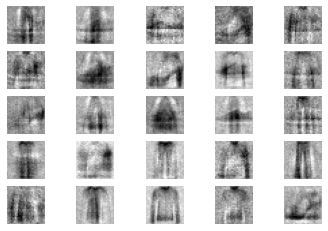


EPOCH: 2200
Discriminator Loss: 8.156163592287768e-07
Accuracy: 200
Generator Loss: 0.022254258394241333
MSE: 0.022276533767580986


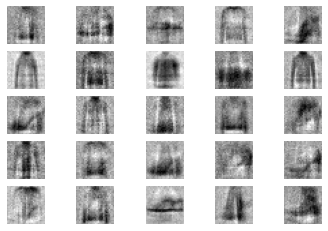


EPOCH: 2250
Discriminator Loss: 2.488818495294254e-06
Accuracy: 200
Generator Loss: 0.01824037730693817
MSE: 0.018258634954690933


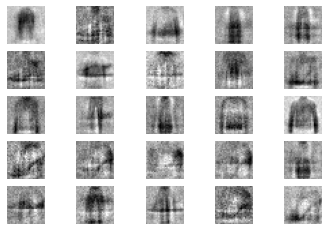


EPOCH: 2300
Discriminator Loss: 1.0304672964922545e-06
Accuracy: 200
Generator Loss: 0.01938631571829319
MSE: 0.019405720755457878


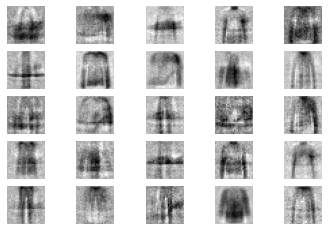


EPOCH: 2350
Discriminator Loss: 7.628348291932596e-08
Accuracy: 200
Generator Loss: 0.01779814064502716
MSE: 0.017815956845879555


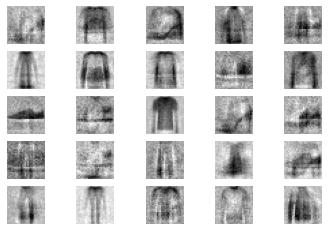


EPOCH: 2400
Discriminator Loss: 1.9932640582531747e-07
Accuracy: 200
Generator Loss: 0.018666991963982582
MSE: 0.018685678020119667


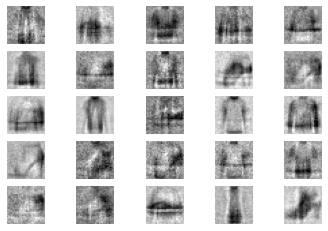


EPOCH: 2450
Discriminator Loss: 6.387447400446611e-07
Accuracy: 200
Generator Loss: 0.024995479732751846
MSE: 0.025020500645041466


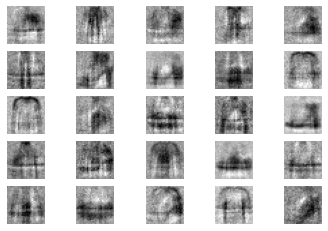


EPOCH: 2500
Discriminator Loss: 9.4556382990163e-07
Accuracy: 200
Generator Loss: 0.013751025311648846
MSE: 0.013764790259301662


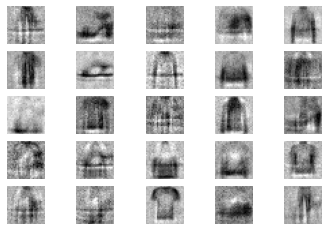


EPOCH: 2550
Discriminator Loss: 5.953517748236159e-08
Accuracy: 200
Generator Loss: 0.01915229670703411
MSE: 0.019171467050909996


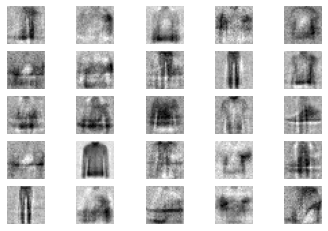


EPOCH: 2600
Discriminator Loss: 1.0389066492505483e-07
Accuracy: 200
Generator Loss: 0.023151207715272903
MSE: 0.023174380883574486


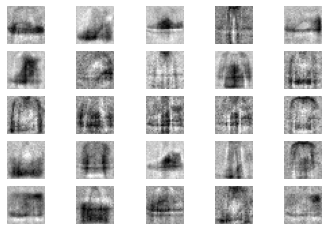


EPOCH: 2650
Discriminator Loss: 2.992643572952147e-07
Accuracy: 200
Generator Loss: 0.0252734012901783
MSE: 0.025298699736595154


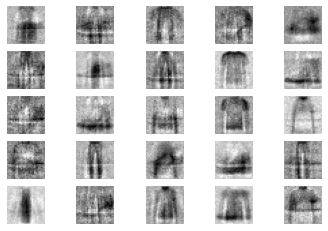


EPOCH: 2700
Discriminator Loss: 5.94952098253998e-07
Accuracy: 200
Generator Loss: 0.015322072431445122
MSE: 0.01533740945160389


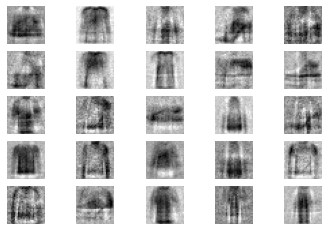


EPOCH: 2750
Discriminator Loss: 6.446500715462378e-07
Accuracy: 200
Generator Loss: 0.018431633710861206
MSE: 0.01845008321106434


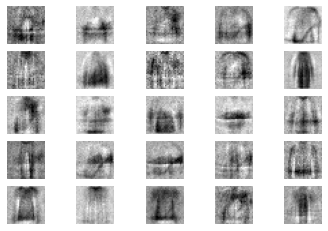


EPOCH: 2800
Discriminator Loss: 5.785748963260673e-09
Accuracy: 200
Generator Loss: 0.018751244992017746
MSE: 0.018770014867186546


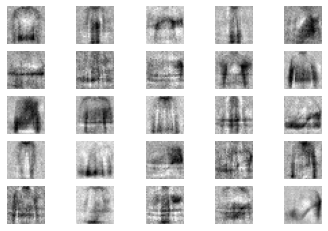


EPOCH: 2850
Discriminator Loss: 5.677136530740645e-07
Accuracy: 200
Generator Loss: 0.017947908490896225
MSE: 0.017965873703360558


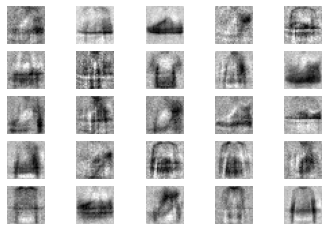


EPOCH: 2900
Discriminator Loss: 1.3597883277427774e-06
Accuracy: 200
Generator Loss: 0.02186785824596882
MSE: 0.02188974805176258


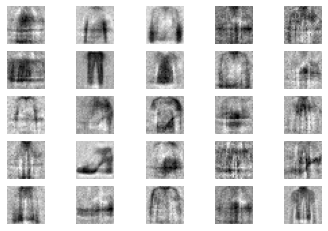


EPOCH: 2950
Discriminator Loss: 5.7864386698858183e-08
Accuracy: 200
Generator Loss: 0.018456364050507545
MSE: 0.018474837765097618


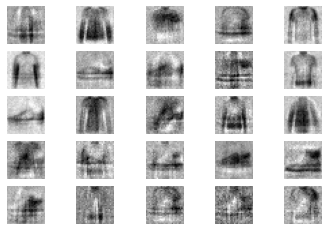


EPOCH: 3000
Discriminator Loss: 1.3486760419567645e-07
Accuracy: 200
Generator Loss: 0.01755519025027752
MSE: 0.017572762444615364


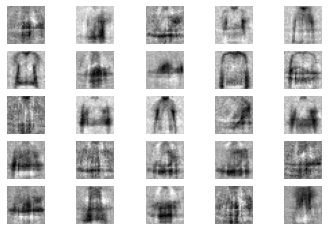


EPOCH: 3050
Discriminator Loss: 6.04703753182001e-08
Accuracy: 200
Generator Loss: 0.019144488498568535
MSE: 0.019163651391863823


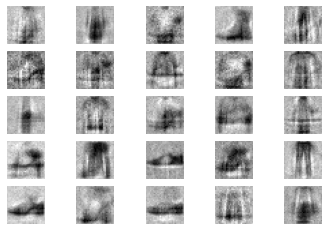


EPOCH: 3100
Discriminator Loss: 2.3053202181239074e-07
Accuracy: 200
Generator Loss: 0.016786929219961166
MSE: 0.01680373214185238


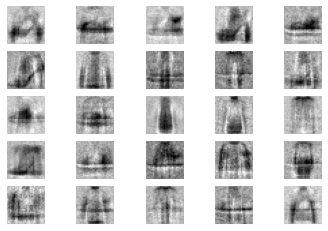


EPOCH: 3150
Discriminator Loss: 3.5925283999732605e-07
Accuracy: 200
Generator Loss: 0.017785292118787766
MSE: 0.017803095281124115


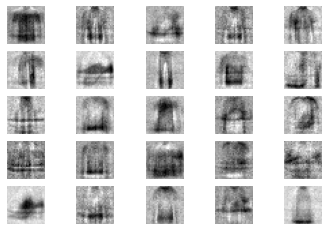


EPOCH: 3200
Discriminator Loss: 1.4001263567639533e-07
Accuracy: 200
Generator Loss: 0.018778357654809952
MSE: 0.01879715546965599


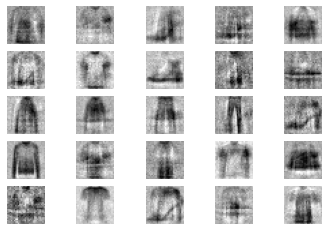


EPOCH: 3250
Discriminator Loss: 4.237168141352221e-08
Accuracy: 200
Generator Loss: 0.017769325524568558
MSE: 0.017787111923098564


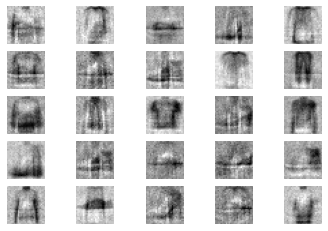


EPOCH: 3300
Discriminator Loss: 9.664872679948644e-08
Accuracy: 200
Generator Loss: 0.015825636684894562
MSE: 0.01584147848188877


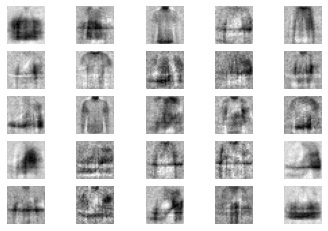


EPOCH: 3350
Discriminator Loss: 1.6179129147531057e-07
Accuracy: 200
Generator Loss: 0.020519737154245377
MSE: 0.020540276542305946


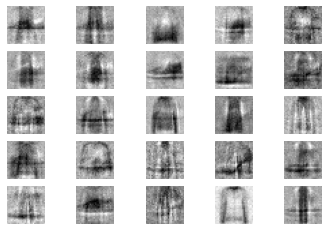


EPOCH: 3400
Discriminator Loss: 2.0961054048029837e-07
Accuracy: 200
Generator Loss: 0.01618690975010395
MSE: 0.01620311290025711


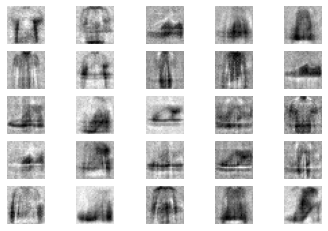


EPOCH: 3450
Discriminator Loss: 2.120877356202866e-07
Accuracy: 200
Generator Loss: 0.01957041025161743
MSE: 0.019589999690651894


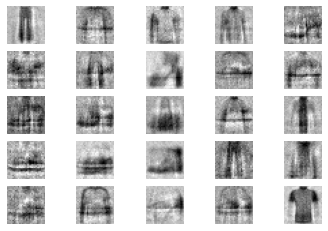


EPOCH: 3500
Discriminator Loss: 1.0377617265522332e-08
Accuracy: 200
Generator Loss: 0.0189192034304142
MSE: 0.01893814094364643


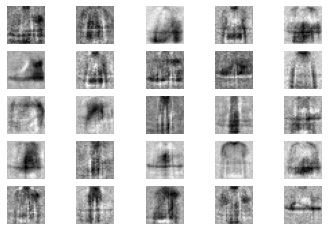


EPOCH: 3550
Discriminator Loss: 7.17372698527128e-08
Accuracy: 200
Generator Loss: 0.016817471012473106
MSE: 0.016834305599331856


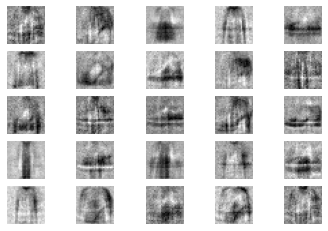


EPOCH: 3600
Discriminator Loss: 4.7687100876068166e-08
Accuracy: 200
Generator Loss: 0.019190378487110138
MSE: 0.019209587946534157


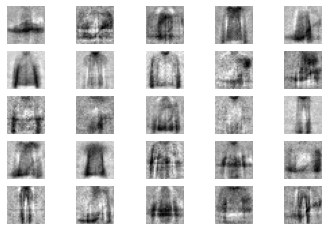


EPOCH: 3650
Discriminator Loss: 1.902080875026968e-07
Accuracy: 200
Generator Loss: 0.01357723493129015
MSE: 0.013590825721621513


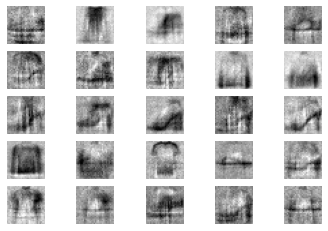


EPOCH: 3700
Discriminator Loss: 1.4725069191756646e-08
Accuracy: 200
Generator Loss: 0.01619645580649376
MSE: 0.016212668269872665


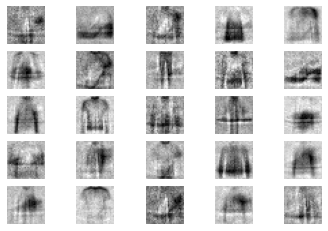


EPOCH: 3750
Discriminator Loss: 8.441885812615624e-08
Accuracy: 200
Generator Loss: 0.016581352800130844
MSE: 0.01659795083105564


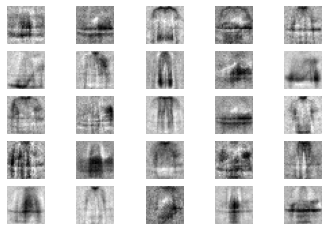


EPOCH: 3800
Discriminator Loss: 1.552176644853409e-08
Accuracy: 200
Generator Loss: 0.02201012521982193
MSE: 0.022032156586647034


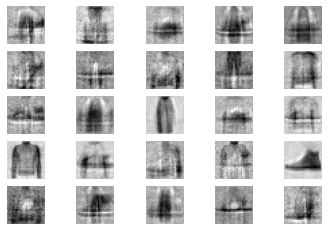


EPOCH: 3850
Discriminator Loss: 4.024456221052297e-08
Accuracy: 200
Generator Loss: 0.017239587381482124
MSE: 0.01725684478878975


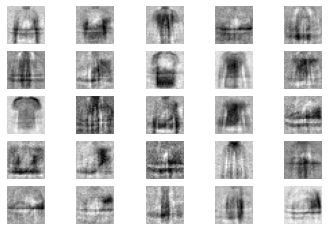


EPOCH: 3900
Discriminator Loss: 4.878548433955574e-08
Accuracy: 200
Generator Loss: 0.02043735980987549
MSE: 0.020457817241549492


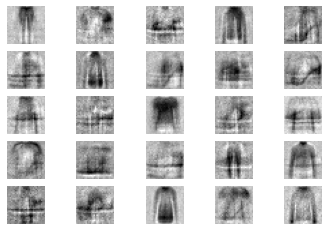


EPOCH: 3950
Discriminator Loss: 7.010046536542851e-08
Accuracy: 200
Generator Loss: 0.016212986782193184
MSE: 0.016229216009378433


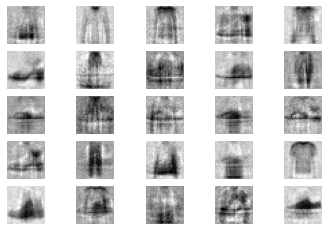


EPOCH: 4000
Discriminator Loss: 1.1470143660829296e-08
Accuracy: 200
Generator Loss: 0.0232095904648304
MSE: 0.023232823237776756


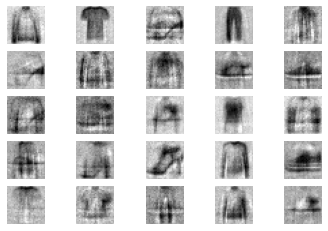


EPOCH: 4050
Discriminator Loss: 7.961977700597254e-09
Accuracy: 200
Generator Loss: 0.014974365010857582
MSE: 0.014989353716373444


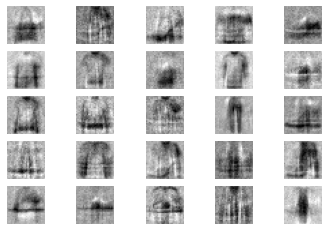


EPOCH: 4100
Discriminator Loss: 1.2685927137909866e-08
Accuracy: 200
Generator Loss: 0.020458022132515907
MSE: 0.020478500053286552


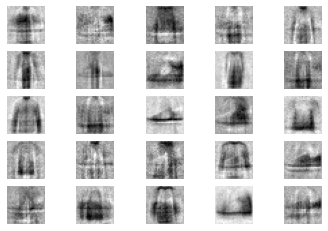


EPOCH: 4150
Discriminator Loss: 7.532132695331484e-09
Accuracy: 200
Generator Loss: 0.017620474100112915
MSE: 0.017638111487030983


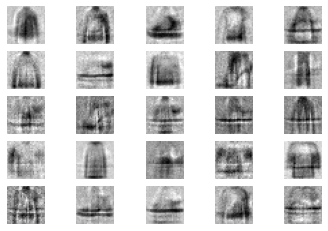


EPOCH: 4200
Discriminator Loss: 8.501397807947342e-09
Accuracy: 200
Generator Loss: 0.019692938774824142
MSE: 0.019712651148438454


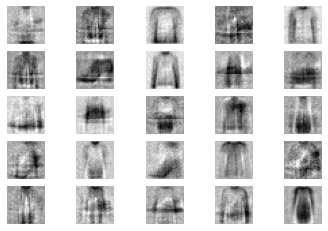


EPOCH: 4250
Discriminator Loss: 4.312443320844683e-08
Accuracy: 200
Generator Loss: 0.018298830837011337
MSE: 0.018317148089408875


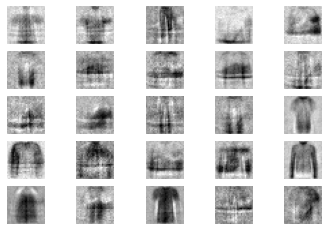


EPOCH: 4300
Discriminator Loss: 2.137440987745598e-08
Accuracy: 200
Generator Loss: 0.016470033675432205
MSE: 0.01648651994764805


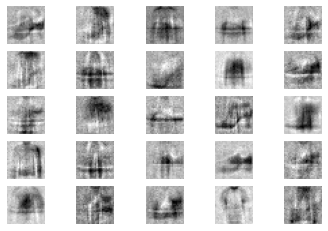


EPOCH: 4350
Discriminator Loss: 1.0829703939174706e-08
Accuracy: 200
Generator Loss: 0.018163232132792473
MSE: 0.018181413412094116


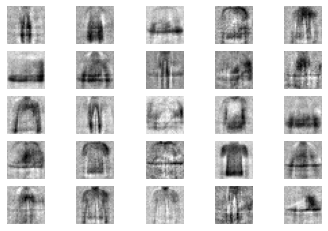


EPOCH: 4400
Discriminator Loss: 4.475576187955299e-08
Accuracy: 200
Generator Loss: 0.01594880037009716
MSE: 0.01596476510167122


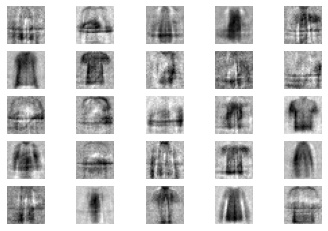


EPOCH: 4450
Discriminator Loss: 9.689211032115619e-08
Accuracy: 200
Generator Loss: 0.017395466566085815
MSE: 0.017412878572940826


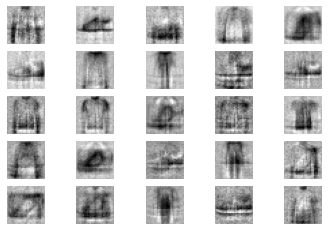


EPOCH: 4500
Discriminator Loss: 1.0796823796122013e-08
Accuracy: 200
Generator Loss: 0.018489394336938858
MSE: 0.018507901579141617


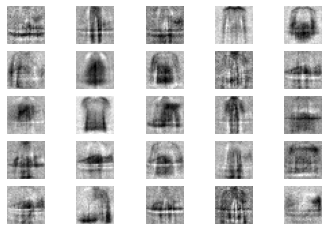


EPOCH: 4550
Discriminator Loss: 4.373654016731621e-08
Accuracy: 200
Generator Loss: 0.015022573061287403
MSE: 0.015037610195577145


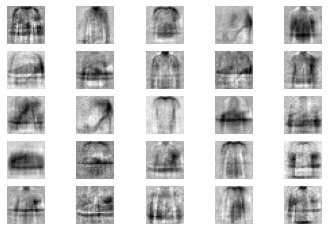


EPOCH: 4600
Discriminator Loss: 1.3214629060454008e-07
Accuracy: 200
Generator Loss: 0.02205629274249077
MSE: 0.022078370675444603


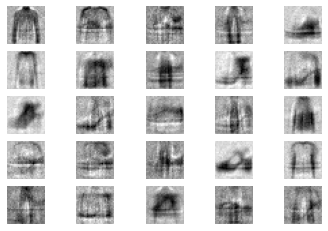


EPOCH: 4650
Discriminator Loss: 5.85623361262777e-09
Accuracy: 200
Generator Loss: 0.016891121864318848
MSE: 0.016908029094338417


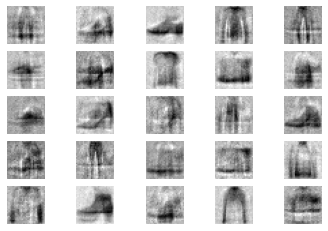


EPOCH: 4700
Discriminator Loss: 1.8001027762143407e-08
Accuracy: 200
Generator Loss: 0.014491557143628597
MSE: 0.014506063424050808


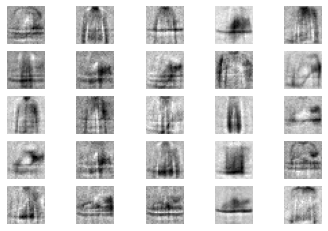


EPOCH: 4750
Discriminator Loss: 1.1854012636130636e-09
Accuracy: 200
Generator Loss: 0.015569270588457584
MSE: 0.0155848553404212


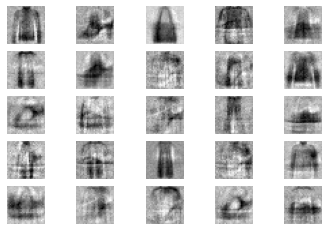


EPOCH: 4800
Discriminator Loss: 4.762886765880065e-07
Accuracy: 200
Generator Loss: 0.01475607231259346
MSE: 0.014770843088626862


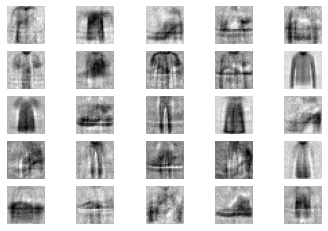


EPOCH: 4850
Discriminator Loss: 8.729296918641438e-08
Accuracy: 200
Generator Loss: 0.015257409773766994
MSE: 0.015272682532668114


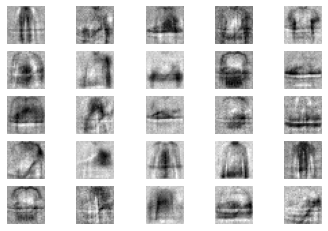


EPOCH: 4900
Discriminator Loss: 1.994933018800195e-08
Accuracy: 200
Generator Loss: 0.013948231004178524
MSE: 0.01396219339221716


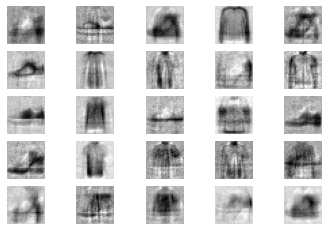


EPOCH: 4950
Discriminator Loss: 1.5858881469328623e-09
Accuracy: 200
Generator Loss: 0.016403265297412872
MSE: 0.016419684514403343


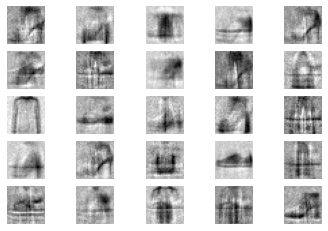


EPOCH: 5000
Discriminator Loss: 5.325777067125233e-09
Accuracy: 200
Generator Loss: 0.013484696857631207
MSE: 0.013498194515705109


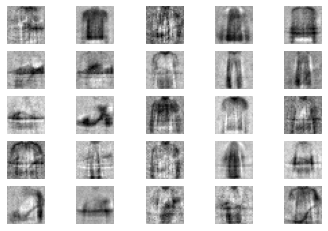


EPOCH: 5050
Discriminator Loss: 7.602462673752844e-08
Accuracy: 200
Generator Loss: 0.01712949573993683
MSE: 0.0171466413885355


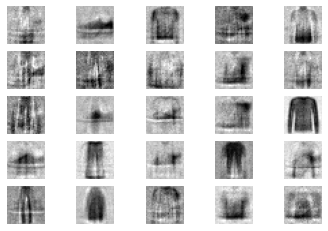


EPOCH: 5100
Discriminator Loss: 7.679760194445606e-08
Accuracy: 200
Generator Loss: 0.013955526985228062
MSE: 0.01396949589252472


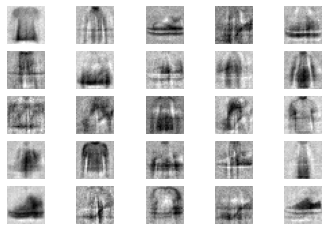


EPOCH: 5150
Discriminator Loss: 7.10766618309572e-09
Accuracy: 200
Generator Loss: 0.015945982187986374
MSE: 0.015961943194270134


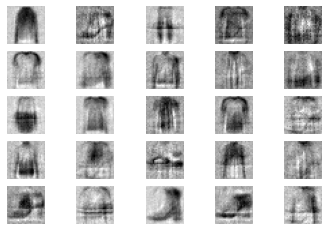


EPOCH: 5200
Discriminator Loss: 8.594813361018083e-09
Accuracy: 200
Generator Loss: 0.014167426154017448
MSE: 0.014181607402861118


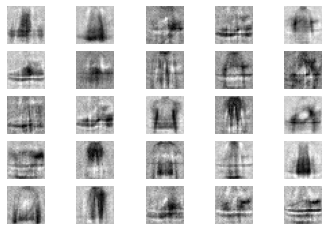


EPOCH: 5250
Discriminator Loss: 1.8056102912746702e-09
Accuracy: 200
Generator Loss: 0.017802391201257706
MSE: 0.017820211127400398


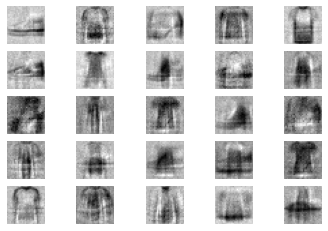


EPOCH: 5300
Discriminator Loss: 4.584121183261744e-09
Accuracy: 200
Generator Loss: 0.018708737567067146
MSE: 0.018727464601397514


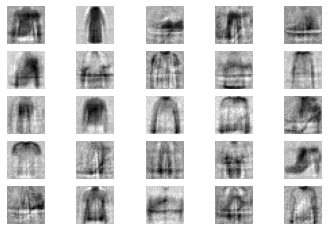


EPOCH: 5350
Discriminator Loss: 2.1691983637507037e-09
Accuracy: 200
Generator Loss: 0.0146825285628438
MSE: 0.014697225764393806


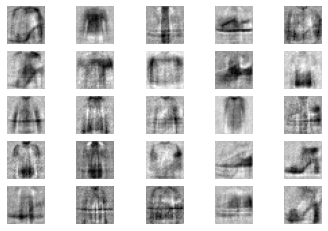


EPOCH: 5400
Discriminator Loss: 2.1241583718746918e-09
Accuracy: 200
Generator Loss: 0.018318327143788338
MSE: 0.018336663022637367


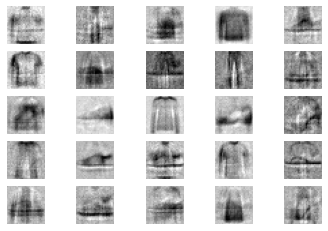


EPOCH: 5450
Discriminator Loss: 1.3740882125575426e-09
Accuracy: 200
Generator Loss: 0.014089509844779968
MSE: 0.01410361286252737


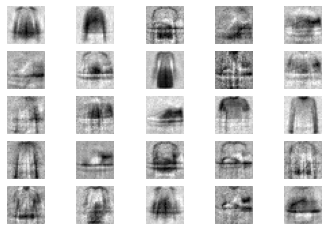


EPOCH: 5500
Discriminator Loss: 1.4580980867151538e-08
Accuracy: 200
Generator Loss: 0.021232731640338898
MSE: 0.021253986284136772


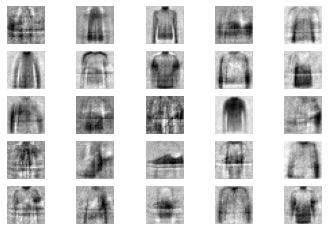


EPOCH: 5550
Discriminator Loss: 3.1850299943375506e-07
Accuracy: 200
Generator Loss: 0.015958081930875778
MSE: 0.015974055975675583


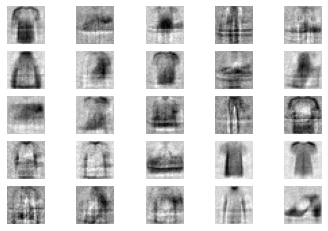


EPOCH: 5600
Discriminator Loss: 6.996902088065256e-10
Accuracy: 200
Generator Loss: 0.015079592354595661
MSE: 0.015094687230885029


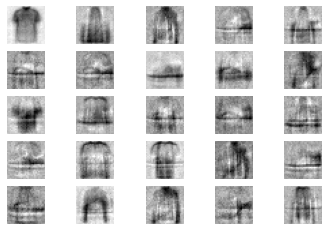


EPOCH: 5650
Discriminator Loss: 3.702347808887119e-08
Accuracy: 200
Generator Loss: 0.01715323142707348
MSE: 0.01717040129005909


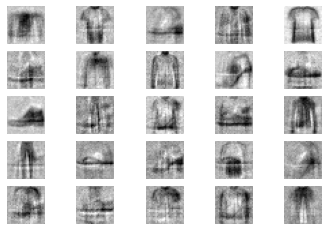


EPOCH: 5700
Discriminator Loss: 9.34792403826625e-10
Accuracy: 200
Generator Loss: 0.016437048092484474
MSE: 0.01645350083708763


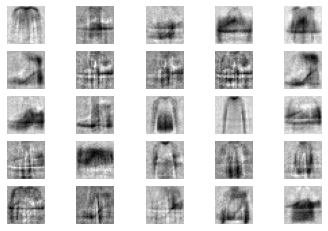


EPOCH: 5750
Discriminator Loss: 8.12436497521496e-08
Accuracy: 200
Generator Loss: 0.020205553621053696
MSE: 0.020225778222084045


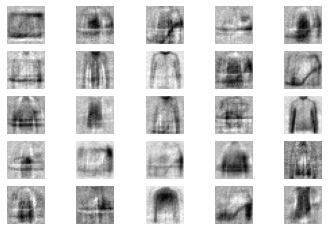


EPOCH: 5800
Discriminator Loss: 6.183527440084546e-09
Accuracy: 200
Generator Loss: 0.014210451394319534
MSE: 0.014224675484001637


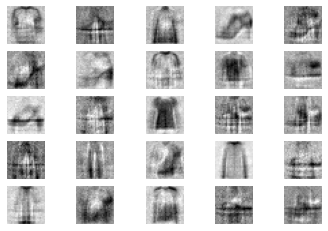


EPOCH: 5850
Discriminator Loss: 3.699974883045372e-09
Accuracy: 200
Generator Loss: 0.014439476653933525
MSE: 0.014453930780291557


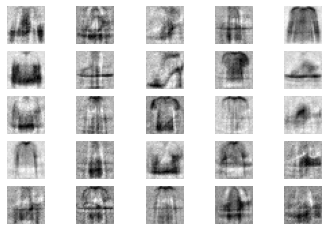


EPOCH: 5900
Discriminator Loss: 6.36691100015796e-09
Accuracy: 200
Generator Loss: 0.01700705848634243
MSE: 0.0170240830630064


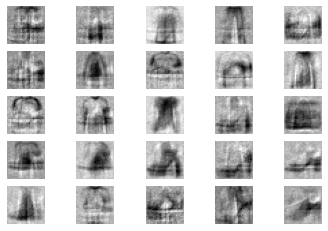


EPOCH: 5950
Discriminator Loss: 1.3824807852322318e-09
Accuracy: 200
Generator Loss: 0.014628536999225616
MSE: 0.014643180184066296


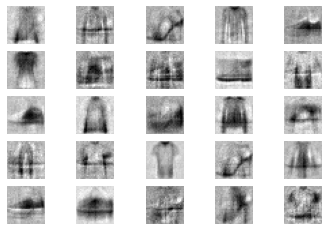

In [ ]:
epochs = 6000
sample_interval = 50
sample_count = epochs/sample_interval

# Let the training Begins
train(epochs = epochs, 
      batch_size = batch_size,
      sample_interval=sample_interval)

# Creating a GIF over the training results

In [ ]:
if not os.path.exists("./Images"):
    os.mkdir("./Images")

imgs = []
for item in os.listdir("./"):
    if item.endswith(".png"):
        imgs.append(item)


In [ ]:
import shutil

for img in imgs:
    shutil.move(f"./{img}", f"./Images/{img}")

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "./Images/fashionMnist_*.png"
fp_out = "./Images/fashionMnist_AAE.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=1000, loop=0)